In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load data
df1 = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df2 = pd.read_csv(r"D:\T\test_codeEVT\nd\moto_smooth.csv")

# Filter specific IDs
ped = df1[df1['Track ID'] == 282].copy()
moto = df2[df2['Track ID'] == 302].copy()

# Vectorized timestamp rounding
EXPORT_INTERVAL = 0.16
ped['TimeStamp_rounded'] = np.round(ped['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL
moto['TimeStamp_rounded'] = np.round(moto['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL

# Vectorized heading calculation
def calculate_heading(vx, vy):
    return np.degrees(np.arctan2(vy, vx)) % 360

ped['heading'] = calculate_heading(ped['vx_smooth'].values, ped['vy_smooth'].values)
moto['heading'] = calculate_heading(moto['vx_smooth'].values, moto['vy_smooth'].values)

# Bounding box dimensions
PED_BOX = (0.3, 0.3)
MOTO_BOX = (1.87, 0.64)
DIST_THRESH = 2

# Vectorized rotated corners calculation
def get_all_rotated_corners(df, box_dim):
    """Vectorized calculation of all rotated corners for a dataframe"""
    half_l, half_w = box_dim[0]/2, box_dim[1]/2
    base_corners = np.array([
        [half_l, half_w],
        [half_l, -half_w],
        [-half_l, -half_w],
        [-half_l, half_w]
    ])
    
    headings_rad = np.radians(df['heading'].values)
    cos = np.cos(headings_rad)
    sin = np.sin(headings_rad)
    
    # Vectorized rotation and translation
    rotated = np.empty((len(df), 4, 2))
    for i in range(4):  # For each corner
        x = base_corners[i, 0]
        y = base_corners[i, 1]
        rotated[:, i, 0] = x * cos - y * sin + df['x_smooth'].values
        rotated[:, i, 1] = x * sin + y * cos + df['y_smooth'].values
    
    return rotated

# Pre-compute all rotated corners
ped_corners_all = get_all_rotated_corners(ped, PED_BOX)
moto_corners_all = get_all_rotated_corners(moto, MOTO_BOX)

# Vectorized temporal matching
TIME_BUFFER = 0.0
ped_times = ped['TimeStamp_rounded'].values
moto_times = moto['TimeStamp_rounded'].values

# Create a grid of time differences
time_diffs = np.abs(ped_times[:, None] - moto_times[None, :])
time_matches = time_diffs <= TIME_BUFFER

# Vectorized center distance calculation
ped_xy = ped[['x_smooth', 'y_smooth']].values
moto_xy = moto[['x_smooth', 'y_smooth']].values
center_dists = np.hypot(
    ped_xy[:, 0, None] - moto_xy[None, :, 0],
    ped_xy[:, 1, None] - moto_xy[None, :, 1]
)

# Find all potential conflicts
conflict_mask = (time_matches) & (center_dists <= DIST_THRESH)
ped_idx, moto_idx = np.where(conflict_mask)

# Vectorized corner distance calculation
# Vectorized corner distance and closing rate calculation
conflicts = []
for p_idx, c_idx in zip(ped_idx, moto_idx):
    # Get the corner coordinates
    ped_corners = ped_corners_all[p_idx]
    moto_corners = moto_corners_all[c_idx]
    
    # Calculate all pairwise distances
    dist_matrix = cdist(ped_corners, moto_corners)
    min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    min_dist = dist_matrix[min_idx]
    
    if min_dist == 0:
        closing_rate = 0  # Collision occurring
    else:
        # Get the direction vector between closest corners
        direction_vec = moto_corners[min_idx[1]] - ped_corners[min_idx[0]]
        unit_vec = direction_vec / min_dist
        
        # Get current rows
        ped_row = ped.iloc[p_idx]
        moto_row = moto.iloc[c_idx]
        
        # Calculate relative velocity and acceleration
        rel_v = np.array([
            ped_row['vx_smooth'] - moto_row['vx_smooth'],
            ped_row['vy_smooth'] - moto_row['vy_smooth']
        ])
        rel_a = np.array([
            ped_row['ax'] - moto_row['ax'],
            ped_row['ay'] - moto_row['ay']
        ]) * 0.5  # 0.5s prediction
        
        # Project onto minimum distance direction
        closing_rate = -np.dot(rel_v, unit_vec) + np.dot(rel_a, unit_vec)
    
    conflicts.append({
        'Ped_Time': ped.iloc[p_idx]['TimeStamp'],
        'Ped_Time_Rounded': ped_times[p_idx],
        'Car_Time': moto.iloc[c_idx]['TimeStamp'],
        'Car_Time_Rounded': moto_times[c_idx],
        'Time_Diff': moto_times[c_idx] - ped_times[p_idx],
        'Center_Distance': center_dists[p_idx, c_idx],
        'Min_Corner_Distance': min_dist,
        'Closing_Rate': closing_rate,
        'ATTC': min_dist/closing_rate if closing_rate > 0 else np.inf,
        'Ped_X': ped_xy[p_idx, 0],
        'Ped_Y': ped_xy[p_idx, 1],
        'Car_X': moto_xy[c_idx, 0],
        'Car_Y': moto_xy[c_idx, 1],
        'Car_Heading': moto.iloc[c_idx]['heading'],
        'Ped_Heading': ped.iloc[p_idx]['heading']
    })

# Create results DataFrame
results = pd.DataFrame(conflicts).drop_duplicates(
    subset=['Ped_Time_Rounded', 'Car_Time_Rounded'], 
    keep='first'
)

In [2]:
if not results.empty:
    print(f"\nConflict Points with ATTC (±{TIME_BUFFER}s, ≤{DIST_THRESH}m):")
    print(results[['Ped_Time_Rounded', 'Car_Time_Rounded', 
                 'Min_Corner_Distance', 'Closing_Rate', 'ATTC']].to_string())


Conflict Points with ATTC (±0.0s, ≤2m):
   Ped_Time_Rounded  Car_Time_Rounded  Min_Corner_Distance  Closing_Rate      ATTC
0            106.56            106.56             0.622870     -5.042810       inf
2            106.88            106.88             0.152890     -2.040113       inf
4            107.20            107.20             0.504374      3.268433  0.154317
6            107.52            107.52             1.129286      0.650452  1.736156


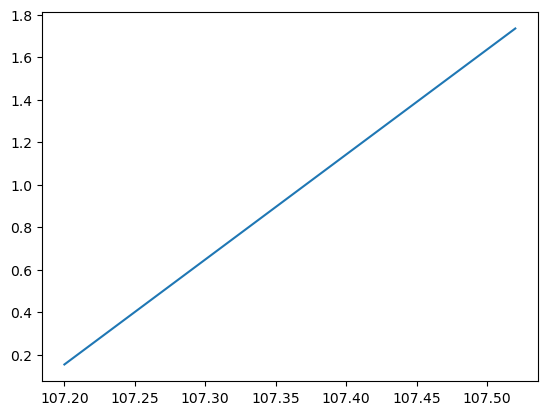

In [4]:
from matplotlib import pyplot as plt
plt.plot(results['Ped_Time_Rounded'],results['ATTC'])

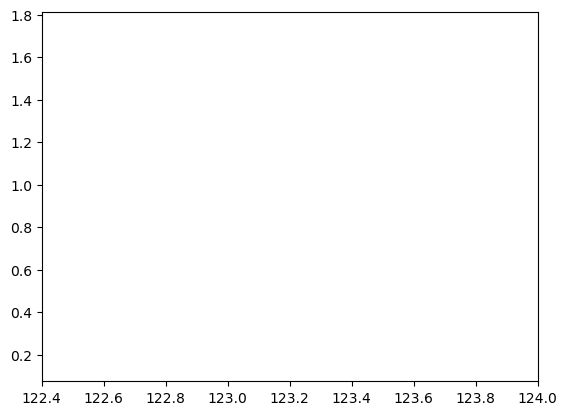

In [5]:
from matplotlib import pyplot as plt
plt.xlim(122.4,124)
plt.plot(results['Ped_Time_Rounded'],results['ATTC'])

In [18]:
results.to_csv(r"D:\T/del2.csv")